In [93]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
import os
import re
# from pandarallel import pandarallel
import keras
# from pivottablejs import pivot_ui
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow
from imblearn.over_sampling import SMOTE
from keras.layers import (Activation, AveragePooling2D, BatchNormalization,
                          Conv2D, Dense, Dropout, Embedding, Flatten, Input,
                          MaxPooling2D)
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import array_to_img
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

In [95]:
emotion_label = {
    0: 'Angry',
    1: 'Disgust', 
    2: 'Fear', 
    3: 'Happy', 
    4: 'Sad', 
    5: 'Surprise', 
    6: 'Neutral'
}

In [96]:
loc = '/content/drive/MyDrive/Study/DS/Computer Vision/Face Emotion Detection/'
# loc = '' 
df = pd.read_csv(f'{loc}data/train.csv')
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [97]:
df = df.sample(frac = 1, random_state = 0)

Sample Image

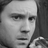

In [98]:
array = np.array(str(df.loc[0, 'pixels']).split(' '), dtype=np.uint8)
array = np.reshape(array, (48, 48))

new_image = Image.fromarray(array)
new_image

### Data Preprocessing

In [99]:
df.isnull().sum()[df.isnull().sum()>0]
# No null values.

Series([], dtype: int64)

In [100]:
df['emotion'] = df['emotion'].astype('category')

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28709 entries, 18082 to 2732
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   emotion  28709 non-null  category
 1   pixels   28709 non-null  object  
dtypes: category(1), object(1)
memory usage: 1.5+ MB


### Univariate Analysis

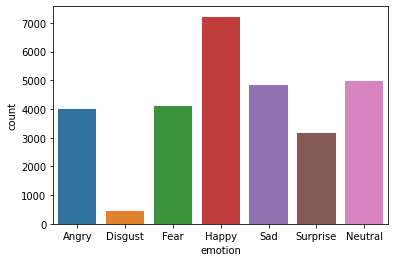

In [102]:
sns.countplot(x = 'emotion', data = df, order = list(emotion_label.keys()))
plt.xticks(ticks = list(emotion_label.keys()), labels = list(emotion_label.values()))
plt.show()

Inference:

1. Disgust values are very less. We could try turning Images at  certain angle to create more data.
2. 

### Feature Engineering

#### Splitting the data in Train and Validation

In [103]:
# def correct_pixel_column(x):
#     x = [int(i) for i in str(x).split(' ')]
#     x = np.asarray(x)
#     x = x / 255
#     x = x.reshape(48, 48)
#     return np.expand_dims(x, -1)
#     # return x.reshape(48, 48)

# # pandarallel.initialize(progress_bar = True)
# df['pixels'] = df['pixels'].apply(correct_pixel_column)
# # df['pixels'] = df['pixels'].parallel_apply(correct_pixel_column)
# df.head()

In [104]:
data = df['pixels'].to_list()
x = []

for j in data:
  xx = [int(i) for i in str(j).split(' ')]
  xx = np.asarray(xx)
  xx = xx / 255
  xx = xx.reshape(48, 48)
  x.append(xx.astype('float32'))

x = np.asarray(x)
x = np.expand_dims(x, -1)

y = df['emotion']

In [105]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.35, random_state=123)
x_train.shape

(18660, 48, 48, 1)

In [106]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([3995,  436, 4097, 7215, 4830, 3171, 4965]))

In [107]:
class_weights = class_weight.compute_class_weight(
        class_weight = 'balanced',
        classes = np.unique(y),
        y = y)

In [108]:
class_weights = dict(zip(np.unique(y), class_weights))
class_weights

{0: 1.0266046844269623,
 1: 9.406618610747051,
 2: 1.0010460615781582,
 3: 0.5684387684387684,
 4: 0.8491274770777877,
 5: 1.293372978330405,
 6: 0.8260394187886635}

### Creating a simple CNN for now.

In [109]:
def cnn_model(input_shape=(48,48,1)):
    # first input model
    visible = Input(shape=input_shape, name='input')
    num_classes = 7
    #the 1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)#the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)#the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    drop3_1 = Dropout(0.3, name = 'drop3_1')(pool3_1)#the 4-th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name = 'drop4_1')(pool4_1)
    
    #the 5-th block
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_4')(conv5_3)
    conv5_3 = BatchNormalization()(conv5_3)
    pool5_1 = MaxPooling2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
    drop5_1 = Dropout(0.3, name = 'drop5_1')(pool5_1)#Flatten and output

    flatten = Flatten(name = 'flatten')(drop5_1)

    ouput = Dense(num_classes, activation='softmax', name = 'output')(flatten)# create model 
    
    model = Model(inputs =visible, outputs = ouput)
    
    return model

In [110]:
model = cnn_model()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [111]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_17 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_18 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 pool1_1 (MaxPooling2D)      (None, 24, 24, 64)        0   

#### Implementing Data Augmentation

In [112]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest'
    )

model.fit( 
    datagen.flow(x, y, batch_size=64, subset='training'),
    validation_data = datagen.flow(x, y, batch_size=64, subset='validation'),
    epochs = 100,
    class_weight = class_weights
    )

Epoch 1/100
359/359 [==============================] - 32s 86ms/step - loss: 2.8869 - accuracy: 0.1497 - val_loss: 1.9590 - val_accuracy: 0.0584
Epoch 2/100
359/359 [==============================] - 28s 79ms/step - loss: 1.9368 - accuracy: 0.1559 - val_loss: 1.9084 - val_accuracy: 0.2034
Epoch 3/100
359/359 [==============================] - 29s 80ms/step - loss: 1.9284 - accuracy: 0.1741 - val_loss: 1.9311 - val_accuracy: 0.1818
Epoch 4/100
359/359 [==============================] - 29s 79ms/step - loss: 1.9249 - accuracy: 0.1739 - val_loss: 1.9036 - val_accuracy: 0.2526
Epoch 5/100
359/359 [==============================] - 29s 80ms/step - loss: 1.9213 - accuracy: 0.1877 - val_loss: 1.9719 - val_accuracy: 0.0667
Epoch 6/100
359/359 [==============================] - 28s 79ms/step - loss: 1.9170 - accuracy: 0.1668 - val_loss: 1.9883 - val_accuracy: 0.1893
Epoch 7/100
359/359 [==============================] - 29s 80ms/step - loss: 1.8903 - accuracy: 0.1874 - val_loss: 1.9110 - val_ac

In [113]:
y_pred = []
y_pred_score = model.predict(x_val)
for i in y_pred_score:
  y_pred.append(i.argmax())

315/315 [==============================] - 4s 13ms/step


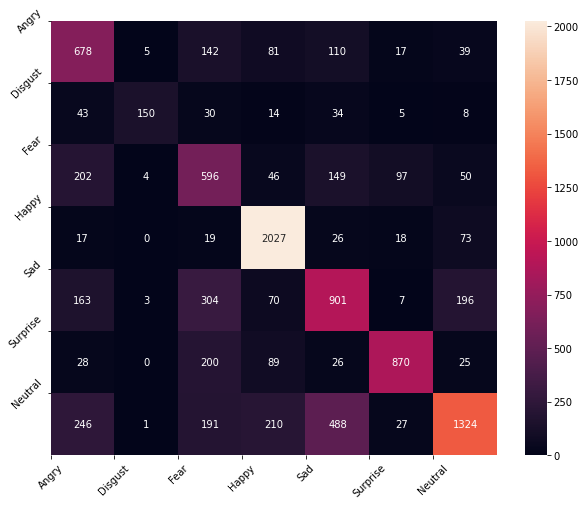

In [114]:
cm = pd.DataFrame(confusion_matrix(y_pred, y_val))
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot=True, fmt='d')
plt.xticks(ticks = list(emotion_label.keys()), labels = list(emotion_label.values()), rotation = 45)
plt.yticks(ticks = list(emotion_label.keys()), labels = list(emotion_label.values()), rotation = 45)
plt.show()

### Saving Model 

In [115]:
default = 'model_'

In [116]:
def ret_latest_file(x):
    ans = os.listdir(f'{loc}/Models/')
    # print(ans)

    finlist = []

    re_pat = re.compile("([a-zA-Z]+_)([0-9]+)")
    for i in ans:
        try:            
            if i[-4:] == 'json':
                res = re_pat.match(i).groups()   #type: ignore 
                # print(res)          
                if res[0] == x:
                    finlist.append(int(res[1]))            
        except:
            pass
    print(finlist)
    if len(finlist) > 0:
        return max(finlist)
    else:
        return 0

In [117]:
# model.save(f'{loc}/Models/model_{ret_latest_file(model_name)}')
name = f'{default}{int(ret_latest_file(default)) + 1}'

model_json = model.to_json()
with open(f'{loc}Models/{name}.json', "w") as json_file:
    json_file.write(model_json)
model.save_weights(f'{loc}Models/{name}.h5')
print("Saved model to disk")

[]
Saved model to disk
